## File for testing the Zone models
This file contains everything needed to test the different zone models. All functions can be edited to test new configurations

In [312]:
import torch
import numpy as np
import pandas as pd
from nsvd import NSVD_Boxes, plot_img
from torchvision import transforms
import random
import folium

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


### Load data and create transformations

In [313]:

tf = transforms.Compose([
transforms.Resize((224,224)),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
])

norm_tf = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

test_data = NSVD_Boxes('./data', train=False, transforms=tf)

{'lat': 69.79704285, 'lng': 19.061281, 'county': 1, 'county_name': 'troms og finnmark', 'angle': 243, 'filename': '07375_0.jpg', 'box_index': 1}


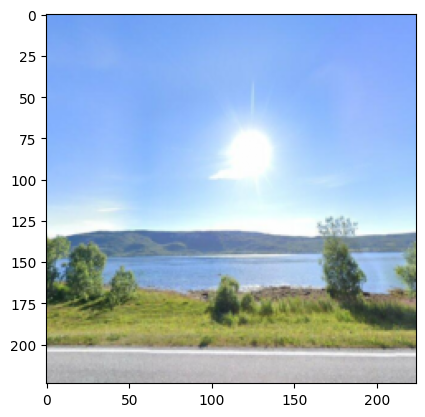

In [314]:
img, data = test_data[random.randint(0, len(test_data)-1)]
print(data)
img = img.to(device)
plot_img(img.cpu())
img = norm_tf(img)

In [315]:
from pyproj import Proj, transform
import geopy.distance
import warnings
warnings.filterwarnings("ignore")

In [316]:
from pyproj import Proj, transform
import geopy.distance
import warnings
warnings.filterwarnings("ignore")

n_list = pd.read_csv('data/NSVD/zone_boxesx200.csv')

gps = Proj(init='epsg:4326')
zone34N = Proj(init='epsg:23034')
def weighted_centroid(points, weights):
    res = points
    while len(res) > 1:
        new_res = []
        new_weights = []
        for i in range(0,len(res),2):
            if i+1 == len(res):
              continue
            p1 = res[i]
            p2 = res[i+1]
            w1 = weights[i]
            w2 = weights[i+1]
            
            vector = np.array(p2) - np.array(p1)
            #length = np.linalg.norm(vector)
            
            percentage = w1 / (w1 + w2)
            p = p1 + percentage*vector

            new_res.append(p)
            new_weights.append(w1 + w2)
        res = new_res
        weights = new_weights
    return res

def centroid(points):
  if type(points[0]) == str:
    points = [tuple(map(float, point[1:-1].split(','))) for point in points]

  x = [p[0] for p in points]
  y = [p[1] for p in points]
  return (sum(x) / len(points), sum(y) / len(points))

def distance_from_point_(y, data): 
  BOX_INDEXES = [43, 75, 22, 11, 31, 64, 77, 23, 33, 53, 21, 54, 76, 32, 42, 74, 86, 12, 87, 85]
  #Get percentage of each box
  print("y", torch.softmax(y, dim=0).numpy())
  
  amt = 3
  y_ = y.topk(amt, dim=0)[1]

  lat, lng = data['lat'], data['lng']
  # Get y_ to the cpu
  y_ = y_.cpu().numpy()
  # Get the box cords for each of the four best y values
  box_cords = n_list.iloc[[BOX_INDEXES[y_[i]] for i in range(len(y_))]]
  box_centers = []
  for i, row in box_cords.iterrows():
    box_centers.append(centroid([row['1'], row['0']]))

  #Calculate new percentage wights
  percentages =  torch.softmax(y, dim=0).detach().cpu().numpy()
  percentages = percentages[[y_[idx] for idx in range(len(y_))]]
  percentages = percentages / percentages.sum()
  
  #Get estimated point
  estimated_point = weighted_centroid(box_centers, torch.softmax(y, dim=0).numpy())[0]
  esitmated_point = transform(zone34N, gps, estimated_point[0], estimated_point[1])
  estimated_point = (esitmated_point[1], esitmated_point[0])
  
  return geopy.distance.geodesic((lat, lng), estimated_point).km, estimated_point

### Run the model on the image and calculate result

In [317]:
model = torch.load('./data/trained_models/zone/norwai_zone')
model.to(device)
model.eval()

with torch.no_grad():
    guess = model(img.unsqueeze(0)).flatten()
    lat, lng = data['lat'], data['lng']
    dict = {}
    dict['lat'] = lat
    dict['lng'] = lng
     
    dist, estimated = distance_from_point_(guess.cpu(), dict)

print(dist)
print(estimated)
    

y [1.7711174e-02 7.5501961e-01 5.1470380e-03 1.8479405e-03 3.3137001e-02
 5.3815514e-02 1.4647117e-03 7.5245334e-04 4.0245478e-04 7.0031397e-03
 6.1356290e-03 5.2601974e-03 9.3222689e-03 1.2509010e-02 4.0011004e-02
 4.1700825e-02 6.6452273e-03 1.6535198e-03 1.8608806e-04 2.7528076e-04]
29.571986754188828
(69.54838613295128, 19.325507167931324)


### Display result on map

In [318]:
m = folium.Map((64.9701, 13.509217), zoom_start=4)

folium.CircleMarker(location=(data['lat'], data['lng']),tooltip='real', radius=5, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(m)
folium.CircleMarker(location=estimated, radius=5, tooltip='estimated', color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(m)
folium.PolyLine(locations=[(data['lat'], data['lng']), estimated], color='blue').add_to(m)

m